 # The Attention Mechanism


Notes on how the attention mechanism works inside Transformers.

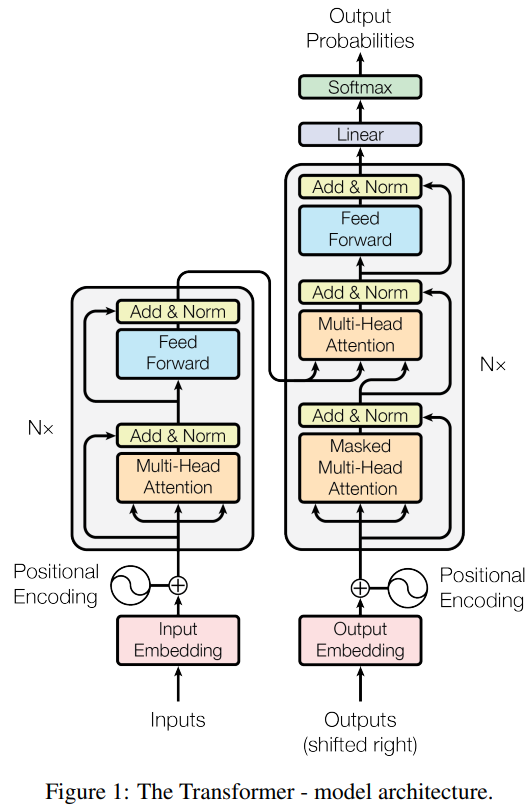
ref: https://arxiv.org/abs/1706.03762v7

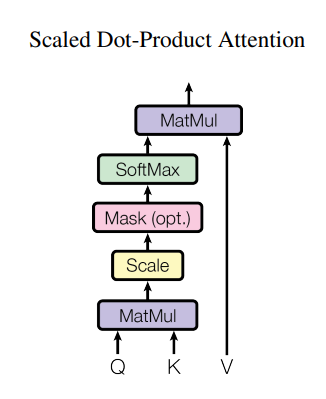

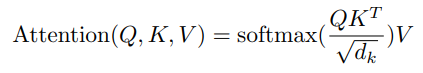

We will Implement Scale Multiplicative Self Attention!!!    ![image.png]

In [51]:
#Imports
import torch
import torch.nn as nn
from torch.nn import functional as F


### So, how do we relate the words?

Let's assume we have our **embeddings** ready (those vector representations of words). We'll call the dimension of these embeddings `d_in` or `emb_d`.

Now, suppose we have a sequence of text with `T` tokens (words/parts of words).

This gives us a matrix `X` with the shape `(T, d_in)`. This is basically our input sentence represented as numbers!

In [52]:
# Let's say our embedding dimension is 4 and we have a sequence of 3 tokens.
d_in = 4
T = 3

# Creating a random input tensor to simulate our embeddings.
# It's just random numbers for now to test the shapes.
x = torch.randn(T, d_in)
x

tensor([[ 1.4786, -0.5896,  1.9454,  0.3652],
        [-0.2261,  0.4935, -0.4355, -0.0453],
        [ 0.2328, -1.2158,  2.8345, -0.3159]])


Okay, the goal of **Attention** is to calculate a "context vector" for each token. This context vector is basically a weighted sum of all the other tokens in the sequence.

To do this, we need **weights** (let's call them `W`). These weights tell us how much "attention" one token should pay to another.

So, the context vector for the i-th token would look something like this:
$$ c_i = \sum_j w_{ij} x_j $$

Wait, this looks a lot like a matrix multiplication! If we have our weights in a matrix `W` (shape `TxT`), we can just do:
$$ C = W \cdot X $$

Let's try to verify this with some code.

In [53]:
# Create a random weight matrix for now just to see if the math works.
weights = torch.randn(T, T)

# Now, we want these weights to sum to 1 for each row (like probabilities).
# So, I'm using softmax on the last dimension.
weights = F.softmax(weights, dim=-1)

# Let's verify the shape and the values.
print("Weights shape:", weights.shape)
print("Weights:\n", weights)

# Calculating the context vectors using matrix multiplication.
# (T, T) @ (T, d_in) -> (T, d_in). The dimensions match!
context = weights @ x
print("\nContext shape:", context.shape)
print("Context:\n", context)

Weights shape: torch.Size([3, 3])
Weights:
 tensor([[0.4627, 0.2315, 0.3058],
        [0.4774, 0.3150, 0.2076],
        [0.4985, 0.2280, 0.2734]])

Context shape: torch.Size([3, 4])
Context:
 tensor([[ 0.7030, -0.5304,  1.6662,  0.0619],
        [ 0.6829, -0.3784,  1.3800,  0.0945],
        [ 0.7492, -0.5138,  1.6456,  0.0853]])


### But wait... where do these weights come from?

We can't just use random weights forever. We need a way to calculate the *affinity* or *similarity* between tokens.

This is where the famous **Query (Q)**, **Key (K)**, and **Value (V)** concepts come in.

* **Query**: What I'm looking for.
* **Key**: What I identify as.
* **Value**: What information I actually hold.

Every token in our sequence will produce these three vectors. We do this by projecting the input `x` using three different linear layers (matrices).

Let's define the dimension of these vectors as `head_size` (or `d_k`, `d_v`).

In [54]:
torch.manual_seed(42)
context_size = 8   # <-- d_k in the paper
emb_d = 32        
head_size = 16   # <-- hyperparameter in atención mechanism

x = torch.randn(context_size, emb_d)
x.shape

torch.Size([8, 32])

In [55]:
key = nn.Linear(emb_d, head_size, bias=False)
query = nn.Linear(emb_d, head_size, bias=False)
value = nn.Linear(emb_d, head_size, bias=False)

In [56]:
k = key(x)
q = query(x)
v = value(x)

q.shape, k.shape

(torch.Size([8, 16]), torch.Size([8, 16]))

### Calculating the Attention Scores (Affinities)

Now for the magic part. To find out how much token `i` relates to token `j`, we calculate the dot product between the **Query** of `i` and the **Key** of `j`.

If we do this for all tokens at once, it's just a matrix multiplication:
$$ \text{scores} = Q \cdot K^T $$

The shape will be `(T, head_size) @ (head_size, T) -> (T, T)`. Perfect! This gives us a score for every pair of tokens.


### Scaling and Normalizing

The raw scores can get pretty big, which messes up the gradients in the softmax. So, we scale them down by dividing by the square root of the head size ($\sqrt{d_k}$).

Then, we apply **softmax** to convert these scores into probabilities (weights that sum to 1).

In [57]:
weights = q @ k.T * context_size ** -.5
weights.shape

torch.Size([8, 8])

In [58]:
weights = F.softmax(weights, dim=-1)
weights

tensor([[0.0600, 0.1994, 0.0525, 0.2421, 0.0779, 0.2070, 0.0691, 0.0919],
        [0.0841, 0.0813, 0.0532, 0.1198, 0.0777, 0.3362, 0.1076, 0.1402],
        [0.0949, 0.1022, 0.0502, 0.1727, 0.1787, 0.1100, 0.0943, 0.1970],
        [0.1098, 0.1129, 0.0984, 0.1111, 0.0851, 0.1850, 0.1635, 0.1342],
        [0.1466, 0.0738, 0.1472, 0.1124, 0.0713, 0.1980, 0.1677, 0.0831],
        [0.0538, 0.0750, 0.0822, 0.0906, 0.0550, 0.4246, 0.1273, 0.0914],
        [0.0402, 0.0680, 0.0658, 0.1026, 0.1635, 0.1933, 0.0812, 0.2854],
        [0.1326, 0.2945, 0.1182, 0.0808, 0.1081, 0.0791, 0.1059, 0.0808]],
       grad_fn=<SoftmaxBackward0>)


### Finally, computing the output!

Now that we have our nice normalized weights, we use them to aggregate the **Values (V)**.

$$ \text{Output} = \text{weights} \cdot V $$

This gives us the new representation for each token, enriched with information from the other tokens it "paid attention" to.

In [59]:
# Aggregating the values.
# (T, T) @ (T, head_size) -> (T, head_size)
out = weights @ v

print("Output shape:", out.shape)
out

Output shape: torch.Size([8, 16])


tensor([[ 0.1554, -0.0044,  0.2840, -0.2357,  0.2205,  0.1362,  0.2419, -0.3230,
         -0.2432,  0.1794, -0.2948, -0.1831,  0.0406,  0.0022, -0.0725, -0.0309],
        [ 0.1053,  0.1033,  0.3122, -0.1599,  0.0945,  0.0509,  0.3413, -0.3533,
         -0.1584,  0.1285, -0.2571, -0.0379, -0.1294,  0.1252, -0.1723,  0.0610],
        [ 0.0083,  0.0903,  0.2253, -0.1663,  0.0203,  0.0265,  0.1836, -0.1306,
         -0.0410,  0.1219, -0.2807, -0.0707, -0.2997, -0.0193, -0.0026, -0.0522],
        [-0.0157,  0.1045,  0.2909, -0.0770,  0.0933,  0.0035,  0.1860, -0.2337,
         -0.1615,  0.1156, -0.3986, -0.0521, -0.2907,  0.0344, -0.1015, -0.0219],
        [-0.0483,  0.1509,  0.3016, -0.0052,  0.0939, -0.1157,  0.1130, -0.2311,
         -0.2077,  0.1194, -0.4530, -0.0672, -0.3795,  0.0516, -0.1146, -0.0576],
        [ 0.1248,  0.0846,  0.3907, -0.1154,  0.1075, -0.0016,  0.3756, -0.4088,
         -0.1911,  0.1156, -0.2956, -0.0311, -0.0665,  0.2057, -0.2515,  0.1158],
        [-0.0462,  0.1

### Look-Ahead Mask (Causal Masking)
In models like the **Transformer** (specifically in the decoder), we need to ensure that the prediction for a specific position depends only on the known outputs at positions before it. 

* **The Problem:** During training, the entire sequence is fed into the model at once. Without a mask, the model could "cheat" by looking at the next words (the "future") to predict the current one.
* **The Solution:** We apply a mask that zeroes out (or sets to $-\infty$) the scores of future tokens in the attention mechanism. This results in a lower triangular matrix where each position can only "see" itself and previous positions.

### Putting it all together in a Module

Okay, doing it step-by-step is great for learning, but let's wrap this into a proper PyTorch `nn.Module` so we can reuse it. This represents a **Single Attention Head**.

In [60]:
class AttentionHead(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(emb_d, head_size, bias=False)
        self.query = nn.Linear(emb_d, head_size, bias=False)
        self.value = nn.Linear(emb_d, head_size, bias=False)
        #self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        #self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.T * C **-.5
        #wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        #wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out

In [61]:
# Let's instantiate our head and test it.
A = AttentionHead(16)

# Passing our input x through the head.
output = A(x)

# It works!
print("Module output:\n", output)

Module output:
 tensor([[-5.9467e-03, -6.5449e-02,  1.4125e-01, -2.2480e-02, -1.8209e-01,
         -3.4449e-03, -4.6510e-01, -2.1807e-01,  1.5599e-01,  2.5021e-01,
         -2.9940e-02, -2.7921e-01,  1.0140e-01, -2.5718e-01,  4.0618e-01,
         -2.7450e-02],
        [-5.5622e-02, -2.0875e-01,  9.7031e-02, -3.4319e-02, -1.9590e-01,
          7.6195e-02, -4.1892e-01, -2.8934e-01,  1.4465e-01,  2.6111e-01,
          3.8971e-02, -2.2483e-01,  2.2967e-02, -1.8875e-01,  3.7208e-01,
         -2.5056e-02],
        [-3.2256e-02, -9.4984e-02,  1.0516e-01, -1.3961e-02, -1.8072e-01,
          4.0841e-02, -4.7185e-01, -2.7365e-01,  1.7108e-01,  2.6744e-01,
          2.9890e-02, -2.6325e-01,  2.9741e-02, -2.4907e-01,  4.0438e-01,
         -3.5520e-02],
        [-5.2397e-02, -2.6912e-01,  8.3292e-02, -4.2679e-02, -2.2598e-01,
          1.0191e-01, -4.2197e-01, -3.0243e-01,  1.3835e-01,  2.6871e-01,
          5.7760e-02, -1.8817e-01,  3.1104e-02, -1.9969e-01,  3.6387e-01,
         -1.2653e-02],
    

In [62]:
# Listing the parameters.
# We expect to see 3 weight matrices here.
list(A.parameters())

[Parameter containing:
 tensor([[-0.1606,  0.1561, -0.0134, -0.0874, -0.0606, -0.1380,  0.1380, -0.0383,
          -0.0994, -0.1341,  0.1033, -0.0244, -0.0186, -0.0461, -0.0853,  0.0314,
           0.1360, -0.1025,  0.0085, -0.1344, -0.0829,  0.1552,  0.0019,  0.1703,
          -0.0310, -0.0964, -0.1056,  0.1567, -0.1359,  0.0928,  0.0439,  0.0522],
         [ 0.0997, -0.0462,  0.1094, -0.1408, -0.0622,  0.1294,  0.0525, -0.0235,
          -0.0413, -0.1079,  0.1075, -0.0056, -0.0060,  0.0418,  0.1305, -0.0902,
          -0.0609,  0.1198,  0.0998, -0.0870, -0.1749,  0.0328,  0.0930,  0.0422,
           0.1254, -0.1403,  0.0891, -0.1099,  0.0995,  0.1315,  0.0560,  0.1430],
         [-0.1165, -0.1581, -0.1700,  0.1110,  0.0619, -0.1294,  0.0856,  0.1613,
          -0.1743,  0.1282,  0.0271,  0.0164,  0.1591,  0.1601,  0.0745,  0.1397,
           0.0735,  0.0288, -0.1554,  0.0330, -0.1258,  0.0544,  0.0312,  0.0040,
          -0.1209, -0.1072,  0.1307,  0.0861,  0.0932, -0.0527, -0.0304, 